# Early Exploration

A script for combining cycling data with weather data and plotting it. Explorative and based on the real data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks
from utils.weather_data import *
from exploration.data_utils import calender_week_to_dates, year_start_end

In [2]:
data = pd.read_csv("../../alle_fahrradzaehler_daten.csv")
data.head()

,timestamp,iso_timestamp,zählstand,stand,standort,channel_name,channel_id,counter_site,counter_site_id,domain_name,domain_id,longitude,latitude,timezone,interval,counter_serial
0,2013-01-01T01:00:00+0000,2013-01-01T01:00:00+0100,15,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
1,2013-01-01T02:00:00+0000,2013-01-01T02:00:00+0100,17,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
2,2013-01-01T03:00:00+0000,2013-01-01T03:00:00+0100,14,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
3,2013-01-01T04:00:00+0000,2013-01-01T04:00:00+0100,13,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
4,2013-01-01T05:00:00+0000,2013-01-01T05:00:00+0100,9,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301


In [3]:
longitude = 9.17467
latitude = 47.66936
locations = ["Stadt Konstanz",  'Stadt Tübingen']

year = 2023
week = 45

In [4]:
from exploration.filter import filter_location_and_time

location = ["Stadt Konstanz"]
start_date = str(year) + "-01-01"
end_date   = str(year) + "-12-31"
single_year_data = filter_location_and_time(data, location, start_date, end_date)
single_year_data = single_year_data.resample('D', on='timestamp')['zählstand'].sum()

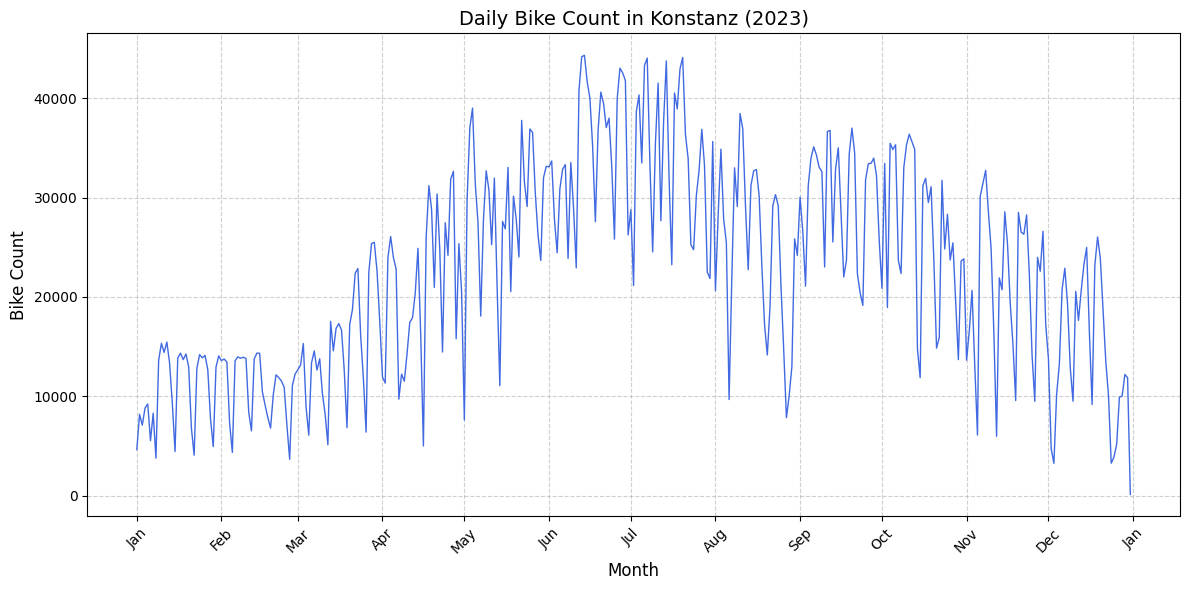

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(single_year_data.index, single_year_data.values, color='royalblue', linewidth=1)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # one tick per month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title("Annual Bike Count in Konstanz (" + str(year) + ")", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Bike Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

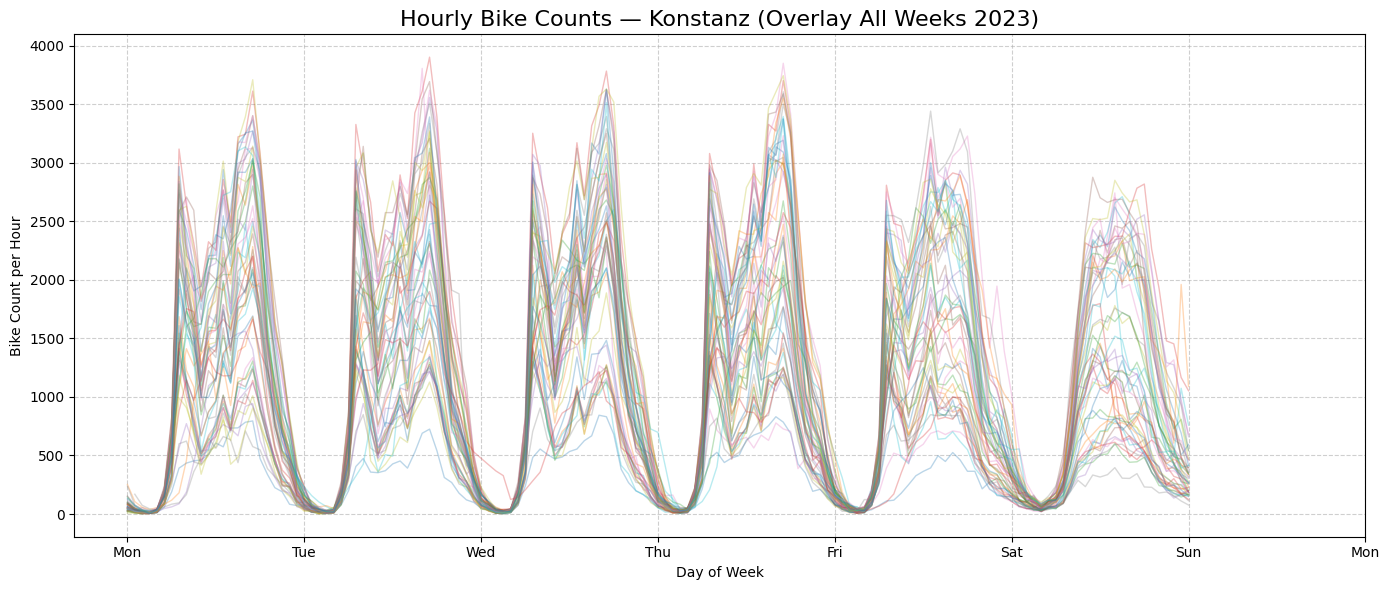

In [6]:
plt.figure(figsize=(14, 6))
start_date, end_date = year_start_end(year)
year_data = filter_location_and_time(data, location, start_date, end_date)
# Loop over all weeks
for cal_week in range(1,52):#week in sorted(konstanz_year_x['iso_week'].unique()):
    start_date, end_date = calender_week_to_dates(year, cal_week)
    one_week = filter_location_and_time(year_data, location, start_date, end_date)
    one_week = one_week.groupby('timestamp', as_index=False).sum(numeric_only=True).sort_values('timestamp')
    one_week = one_week[['timestamp', 'zählstand']].copy()
    one_week['relative_time'] = (one_week['timestamp'].dt.tz_localize(None) - pd.to_datetime(start_date).tz_localize(None)).dt.total_seconds() / 3600  # hours since week start
    plt.plot(one_week['relative_time'], one_week['zählstand'], alpha=0.3, linewidth=1)

# --- 3. Format x-axis to show day labels ---
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 24)))  # tick every day
ax.set_xticks([24 * i for i in range(8)])  # 0h, 24h, ..., 168h
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon'])

plt.title('Hourly Bike Counts — Konstanz (Overlay All Weeks ' + str(year) + ')', fontsize=16)
plt.xlabel('Day of Week')
plt.ylabel('Bike Count per Hour')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [7]:
start_date,end_date = calender_week_to_dates(year, week)
one_week = filter_location_and_time(data, location, start_date, end_date)
one_week = one_week.groupby('timestamp', as_index=False).sum(numeric_only=True).sort_values('timestamp')
one_week = one_week[['timestamp', 'zählstand']].copy()

peak_indices, _ = find_peaks(one_week['zählstand'], height=0)  # height=0 detects all local maxima
peak_times = one_week['timestamp'].iloc[peak_indices]
peak_values = one_week['zählstand'].iloc[peak_indices]

one_week.head()

,timestamp,zählstand
0,2023-11-06 00:00:00+00:00,39
1,2023-11-06 01:00:00+00:00,25
2,2023-11-06 02:00:00+00:00,9
3,2023-11-06 03:00:00+00:00,5
4,2023-11-06 04:00:00+00:00,24


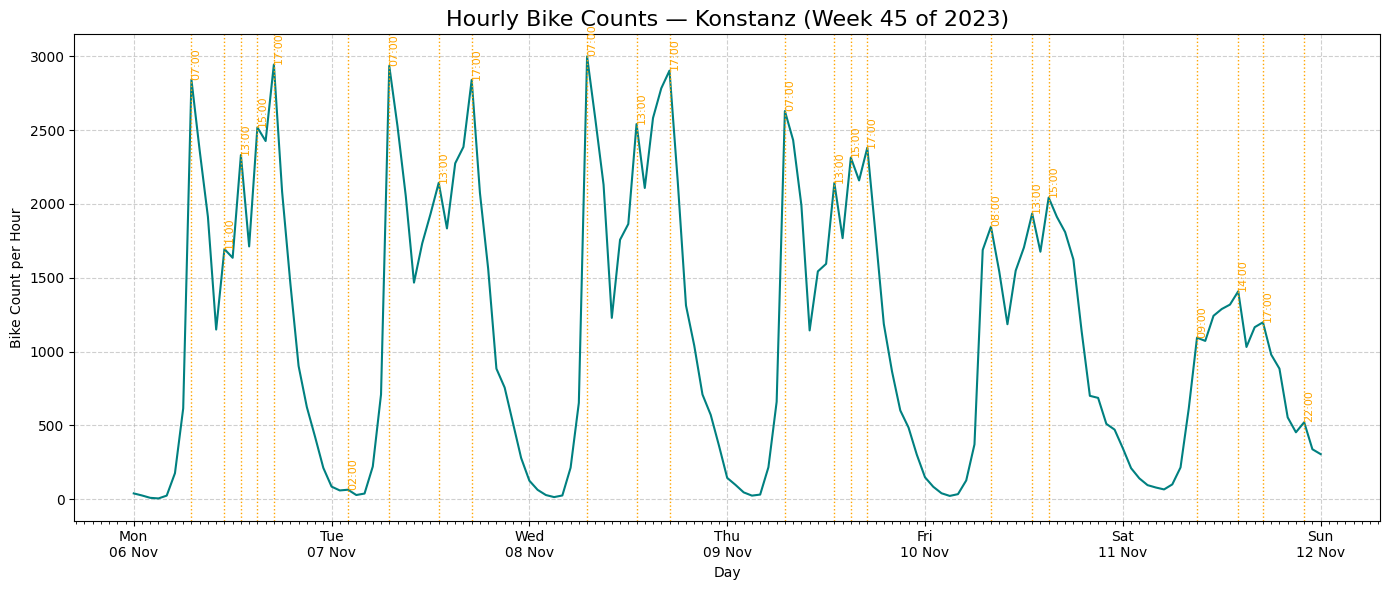

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(one_week['timestamp'], one_week['zählstand'], color='teal', linewidth=1.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())  # one major tick per day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d %b'))

ax.xaxis.set_minor_locator(mdates.HourLocator())

for t, v in zip(peak_times, peak_values):
    plt.axvline(x=t, color='orange', linestyle=':', linewidth=1)
    plt.text(t, v + 1, t.strftime('%H:%M'), rotation=90, verticalalignment='bottom', color='orange', fontsize=8)

plt.xticks(rotation=0)

plt.title('Hourly Bike Counts — Konstanz (Week ' + str(week) + ' of ' + str(year) + ')', fontsize=16)
plt.xlabel('Day')
plt.ylabel('Bike Count per Hour')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [10]:
filtered_data = filter_location_and_time(data, locations, start_date, end_date)
filtered_data = filtered_data.groupby('timestamp', as_index=False).sum(numeric_only=True).sort_values('timestamp')
filtered_data = filtered_data[['timestamp', 'zählstand']].copy()
weather_data = get_full_weather_data(start_date, end_date, longitude, latitude)
combined_data = merge_bike_weather(filtered_data, weather_data)
combined_data.head()

,timestamp,zählstand,rain,snowfall,forecast_rain,forecast_snowfall
0,2023-11-06 00:00:00+00:00,164,False,False,True,False
1,2023-11-06 01:00:00+00:00,141,True,False,True,False
2,2023-11-06 02:00:00+00:00,54,False,False,True,False
3,2023-11-06 03:00:00+00:00,36,True,False,True,False
4,2023-11-06 04:00:00+00:00,55,False,False,True,False


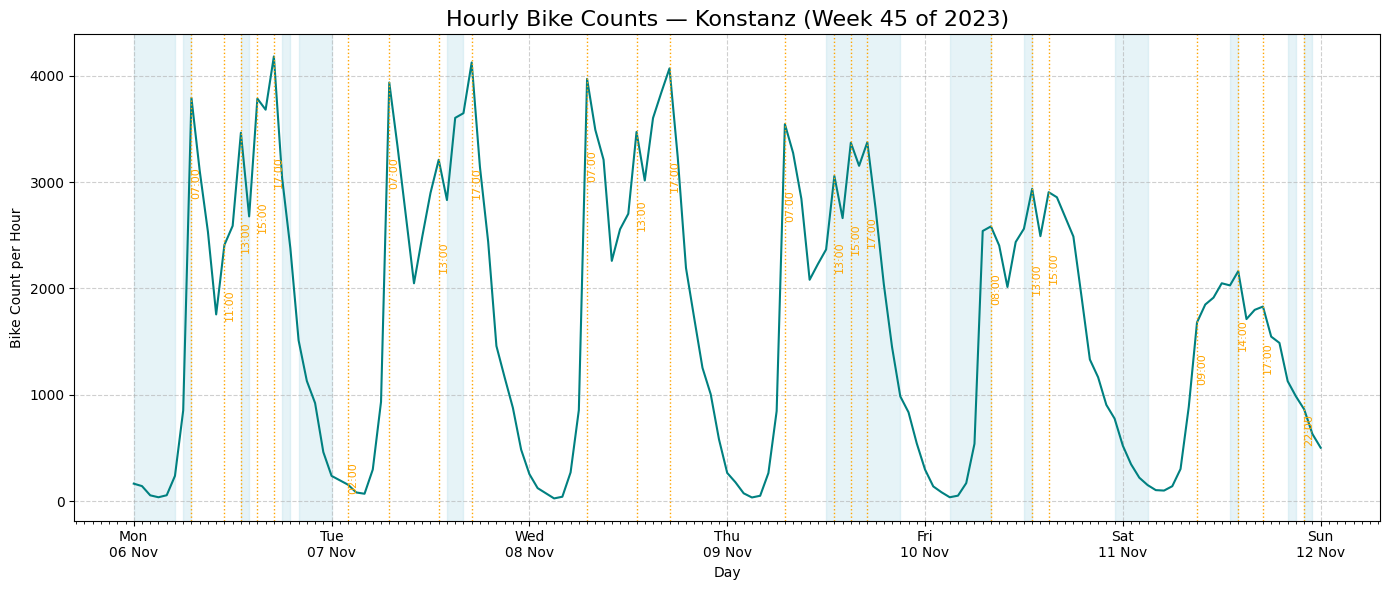

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(combined_data['timestamp'], combined_data['zählstand'], color='teal', linewidth=1.5)

ax = plt.gca()

# --- Highlight rainy/snowy periods ---
# Find consecutive periods where rain or snow is True
in_weather = False
start_time = None

for i, row in combined_data.iterrows():
    if row['forecast_rain'] or row['forecast_snowfall']:
        if not in_weather:
            # Start of a rainy/snowy period
            start_time = row['timestamp']
            in_weather = True
    else:
        if in_weather:
            # End of a rainy/snowy period
            end_time = row['timestamp']
            ax.axvspan(start_time, end_time, color='lightblue', alpha=0.3)
            in_weather = False

# Catch if the last row is still in a rainy/snowy period
if in_weather:
    ax.axvspan(start_time, combined_data['timestamp'].iloc[-1], color='lightblue', alpha=0.3)

ax.xaxis.set_major_locator(mdates.DayLocator())  # one major tick per day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d %b'))

ax.xaxis.set_minor_locator(mdates.HourLocator())

for t, v in zip(peak_times, peak_values):
    plt.axvline(x=t, color='orange', linestyle=':', linewidth=1)
    plt.text(t, v + 1, t.strftime('%H:%M'), rotation=90, verticalalignment='bottom', color='orange', fontsize=8)

plt.xticks(rotation=0)

plt.title('Hourly Bike Counts — Konstanz (Week ' + str(week) + ' of ' + str(year) + ')', fontsize=16)
plt.xlabel('Day')
plt.ylabel('Bike Count per Hour')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

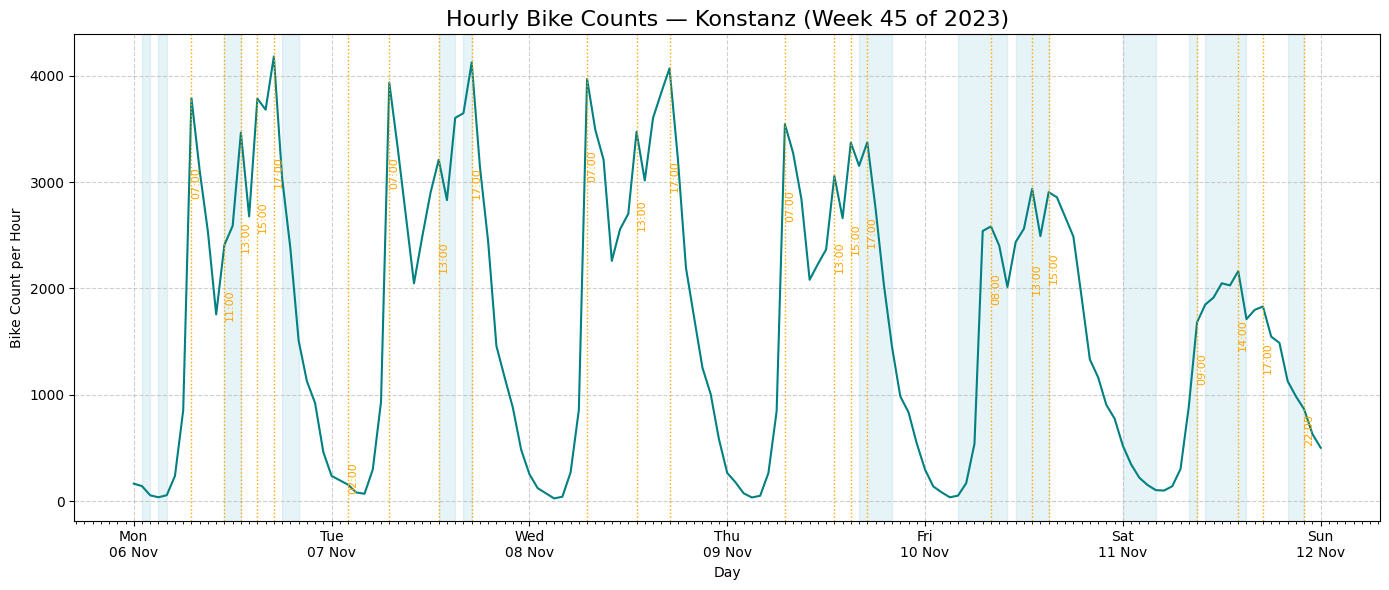

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(combined_data['timestamp'], combined_data['zählstand'], color='teal', linewidth=1.5)

ax = plt.gca()

# --- Highlight rainy/snowy periods ---
# Find consecutive periods where rain or snow is True
in_weather = False
start_time = None

for i, row in combined_data.iterrows():
    if row['rain'] or row['snowfall']:
        if not in_weather:
            # Start of a rainy/snowy period
            start_time = row['timestamp']
            in_weather = True
    else:
        if in_weather:
            # End of a rainy/snowy period
            end_time = row['timestamp']
            ax.axvspan(start_time, end_time, color='lightblue', alpha=0.3)
            in_weather = False

# Catch if the last row is still in a rainy/snowy period
if in_weather:
    ax.axvspan(start_time, combined_data['timestamp'].iloc[-1], color='lightblue', alpha=0.3)

ax.xaxis.set_major_locator(mdates.DayLocator())  # one major tick per day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d %b'))

ax.xaxis.set_minor_locator(mdates.HourLocator())

for t, v in zip(peak_times, peak_values):
    plt.axvline(x=t, color='orange', linestyle=':', linewidth=1)
    plt.text(t, v + 1, t.strftime('%H:%M'), rotation=90, verticalalignment='bottom', color='orange', fontsize=8)

plt.xticks(rotation=0)

plt.title('Hourly Bike Counts — Konstanz (Week ' + str(week) + ' of ' + str(year) + ')', fontsize=16)
plt.xlabel('Day')
plt.ylabel('Bike Count per Hour')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Comparison rain no rain

In [14]:
filtered_data = filter_location_and_time(data, locations, start_date, end_date)
weather_data = get_full_weather_data(start_date, end_date, longitude, latitude)
combined_data = merge_bike_weather(filtered_data, weather_data)


combined_data['hour'] = combined_data['timestamp'].dt.hour
combined_data['weekday'] = combined_data['timestamp'].dt.dayofweek  # 0=Mo

# thresholds based on percentiles
low_thr = combined_data['zählstand'].quantile(0.25)
high_thr = combined_data['zählstand'].quantile(0.75)

combined_data['is_high'] = combined_data['zählstand'] >= high_thr
combined_data.head()

,timestamp,iso_timestamp,zählstand,stand,standort,channel_name,channel_id,counter_site,counter_site_id,domain_name,...,timezone,interval,counter_serial,rain,snowfall,forecast_rain,forecast_snowfall,hour,weekday,is_high
0,2023-11-06 00:00:00+00:00,2023-11-06T00:00:00+0100,49,0,Stadt Tübingen,Richtung Altstadt,101003358,Fuß- & Radtunnel Südportal - Derendinger Allee,100003358,Stadt Tübingen,...,(UTC+01:00) Europe/Paris;DST,15,YAH24052174,False,False,True,False,0,0,True
1,2023-11-06 01:00:00+00:00,2023-11-06T01:00:00+0100,51,0,Stadt Tübingen,Richtung Altstadt,101003358,Fuß- & Radtunnel Südportal - Derendinger Allee,100003358,Stadt Tübingen,...,(UTC+01:00) Europe/Paris;DST,15,YAH24052174,True,False,True,False,1,0,True
2,2023-11-06 02:00:00+00:00,2023-11-06T02:00:00+0100,25,0,Stadt Tübingen,Richtung Altstadt,101003358,Fuß- & Radtunnel Südportal - Derendinger Allee,100003358,Stadt Tübingen,...,(UTC+01:00) Europe/Paris;DST,15,YAH24052174,False,False,True,False,2,0,False
3,2023-11-06 03:00:00+00:00,2023-11-06T03:00:00+0100,20,0,Stadt Tübingen,Richtung Altstadt,101003358,Fuß- & Radtunnel Südportal - Derendinger Allee,100003358,Stadt Tübingen,...,(UTC+01:00) Europe/Paris;DST,15,YAH24052174,True,False,True,False,3,0,False
4,2023-11-06 04:00:00+00:00,2023-11-06T04:00:00+0100,13,0,Stadt Tübingen,Richtung Altstadt,101003358,Fuß- & Radtunnel Südportal - Derendinger Allee,100003358,Stadt Tübingen,...,(UTC+01:00) Europe/Paris;DST,15,YAH24052174,False,False,True,False,4,0,False


In [15]:
# conditional probability P(high | rain)
p_high_given_rain = combined_data[combined_data['rain']]['is_high'].mean()

# conditional probability P(high | no rain)
p_high_given_no_rain = combined_data[~combined_data['rain']]['is_high'].mean()

print("P(high | rain)     =", p_high_given_rain)
print("P(high | no rain) =", p_high_given_no_rain)
print("Difference =", p_high_given_no_rain - p_high_given_rain)

grouped = combined_data.groupby(['hour', 'rain'])['is_high'].mean().unstack()

print("P(high | rain, hour):")
print(grouped)

combined_data['forecast_rain'] = combined_data['forecast_rain'].astype(bool)

# forecast effect
p_high_given_forecast_rain = combined_data[combined_data['forecast_rain']]['is_high'].mean()
p_high_given_forecast_no_rain = combined_data[~combined_data['forecast_rain']]['is_high'].mean()

# actual effect
p_high_given_actual_rain = combined_data[combined_data['rain']]['is_high'].mean()
p_high_given_actual_no_rain = combined_data[~combined_data['rain']]['is_high'].mean()

print("Forecast effect:")
print("P(high | forecast rain)     =", p_high_given_forecast_rain)
print("P(high | forecast no rain) =", p_high_given_forecast_no_rain)
print("Δ_forecast =", p_high_given_forecast_no_rain - p_high_given_forecast_rain)

print("\nActual effect:")
print("P(high | actual rain)    =", p_high_given_actual_rain)
print("P(high | actual no rain) =", p_high_given_actual_no_rain)
print("Δ_actual =", p_high_given_actual_no_rain - p_high_given_actual_rain)

P(high | rain)     = 0.2842857142857143
P(high | no rain) = 0.24204545454545454
Difference = -0.04224025974025977
P(high | rain, hour):
rain     False     True 
hour                    
0     0.037500  0.050000
1     0.006250  0.025000
2     0.000000  0.000000
3     0.000000  0.000000
4     0.000000  0.000000
5     0.005000  0.000000
6     0.160000  0.100000
7     0.340000  0.425000
8     0.437500  0.312500
9     0.375000  0.400000
10    0.375000  0.375000
11    0.400000  0.391667
12    0.400000  0.383333
13    0.458333  0.433333
14    0.425000  0.416667
15    0.441667       NaN
16    0.425000  0.450000
17    0.430000  0.425000
18    0.387500  0.412500
19    0.350000  0.337500
20    0.295000  0.100000
21    0.180000  0.125000
22    0.158333       NaN
23    0.087500       NaN
Forecast effect:
P(high | forecast rain)     = 0.22777777777777777
P(high | forecast no rain) = 0.2603211009174312
Δ_forecast = 0.03254332313965344

Actual effect:
P(high | actual rain)    = 0.2842857142857143
P(hi

In [28]:
start_date,end_date = year_start_end(2022)
locations = ["Stadt Konstanz"]
year_data = filter_location_and_time(data, locations, start_date, end_date)
weather_data = get_weather_data(start_date, end_date, longitude, latitude, False)
full_data = merge_bike_weather(year_data, weather_data)
full_data['timestamp'] = pd.to_datetime(full_data['timestamp'], utc=True)
full_data['timestamp_local'] = full_data['timestamp'].dt.tz_convert('Europe/Berlin')
full_data['date'] = full_data['timestamp_local'].dt.date

daily = full_data.groupby('date').agg({
    'zählstand': 'sum',
    'rain': 'max',       # True if any row has True
    'snowfall': 'max'    # True if any row has True
}).reset_index()

print(daily.head())
print(daily.tail())

         date  zählstand   rain  snowfall
0  2022-01-01       3120  False     False
1  2022-01-02       3181  False     False
2  2022-01-03       7786  False     False
3  2022-01-04       7565   True     False
4  2022-01-05       7616   True      True
           date  zählstand   rain  snowfall
360  2022-12-27       5953   True     False
361  2022-12-28       6360  False     False
362  2022-12-29       5991   True     False
363  2022-12-30       6623   True     False
364  2022-12-31        149   True     False


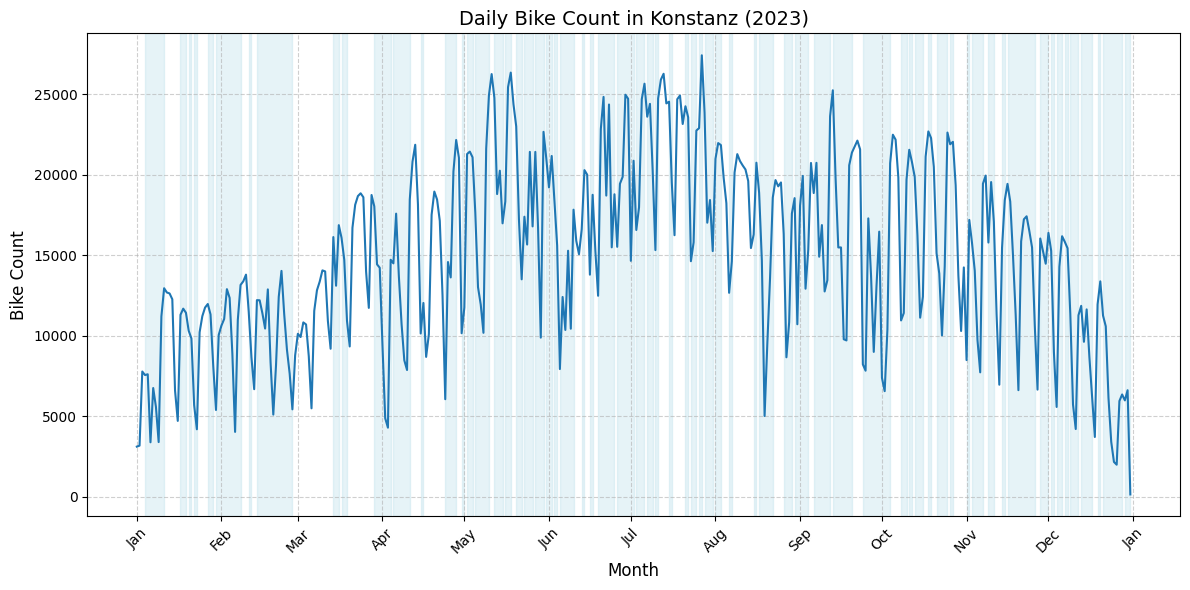

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(daily['date'], daily['zählstand'])
ax = plt.gca()

in_weather = False
start_time = None

for i, row in daily.iterrows():
    if row['rain'] or row['snowfall']:
        if not in_weather:
            # Start of a rainy/snowy period
            start_time = row['date']
            in_weather = True
    else:
        if in_weather:
            # End of a rainy/snowy period
            end_time = row['date']
            ax.axvspan(start_time, end_time, color='lightblue', alpha=0.3)
            in_weather = False

# Catch if the last row is still in a rainy/snowy period
if in_weather:
    ax.axvspan(start_time, daily['date'].iloc[-1], color='lightblue', alpha=0.3)


ax.xaxis.set_major_locator(mdates.MonthLocator())  # one tick per month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title("Daily Bike Count in Konstanz (" + str(year) + ")", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Bike Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()